In [1]:
from __future__ import division, print_function
import sys, os, glob, time, warnings, gc
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table, vstack, hstack, join
import fitsio

In [2]:
params = {'legend.fontsize': 'x-large',
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large',
         'figure.facecolor':'w'} 
plt.rcParams.update(params)

In [3]:
fail_threshold = 0.0033
deep_dchi2 = 100
mindepth = 120

In [10]:
tp = 'ELG'
release = 'cascades'
ver = '3'

f = fitsio.read('/global/cfs/cdirs/desi/survey/catalogs/SV1/redshift_comps/'+release+'/'+ver+'/'+tp+'/alltiles_'+tp+'zinfo.fits') #fitsio *much* faster than using Table here
deep = f[f['subset']=='deep'] 
min_depth = np.max(deep['R_DEPTH'])/2

print('total number, total deep, min depth for deep')
print(len(f),len(deep),min_depth)

total number, total deep, min depth for deep
641432 101763 8718.800033569336


In [13]:
#split deep off from the rest, then join back based on targetid
#rows without truth have z==0

wd = f['subset'] == 'deep'
fd = f[wd]

fnd = f[~wd]
wna = fnd['subset'] != 'all' #remove all type reduction from consideration
fnd = fnd[wna]

fj = join(fnd,fd,join_type='left',keys='TARGETID',table_names=['','_deep'],uniq_col_name='{col_name}{table_name}')


In [14]:
fj.columns #now we have a copy of all of the deep info attached to each other individual redshift

<TableColumns names=('TARGETID','CHI2','COEFF','Z','ZERR','ZWARN','NPIXELS','SPECTYPE','SUBTYPE','NCOEFF','DELTACHI2','NUMEXP','NUMTILE','PETAL_LOC','DEVICE_LOC','LOCATION','FIBER','FIBERSTATUS','TARGET_RA','TARGET_DEC','PMRA','PMDEC','REF_EPOCH','LAMBDA_REF','FA_TARGET','FA_TYPE','OBJTYPE','NUMTARGET','PRIORITY','SUBPRIORITY','OBSCONDITIONS','MORPHTYPE','FLUX_G','FLUX_R','FLUX_Z','FLUX_IVAR_G','FLUX_IVAR_R','FLUX_IVAR_Z','REF_ID','REF_CAT','GAIA_PHOT_G_MEAN_MAG','GAIA_PHOT_BP_MEAN_MAG','GAIA_PHOT_RP_MEAN_MAG','PARALLAX','EBV','FLUX_W1','FLUX_W2','FIBERFLUX_G','FIBERFLUX_R','FIBERFLUX_Z','FIBERTOTFLUX_G','FIBERTOTFLUX_R','FIBERTOTFLUX_Z','MASKBITS','SERSIC','SHAPE_R','SHAPE_E1','SHAPE_E2','PHOTSYS','SV1_DESI_TARGET','SV1_BGS_TARGET','SV1_MWS_TARGET','PRIORITY_INIT','NUMOBS_INIT','RELEASE','BRICKID','BRICKNAME','BRICK_OBJID','BLOBDIST','FIBERFLUX_IVAR_G','FIBERFLUX_IVAR_R','FIBERFLUX_IVAR_Z','DESI_TARGET','BGS_TARGET','MWS_TARGET','HPXPIXEL','TILEID','COADD_NUMEXP','COADD_EXPTIME','MEAN

number, fraction of failures, fraction of failures with zwarn==0
34170 0.11314018144571261 0.061018437225636525


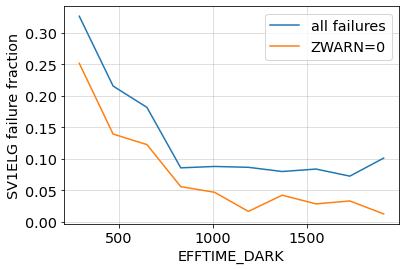

In [23]:
mask = fj['FIBERSTATUS_deep']==0 # Remove FIBERSTATUS!=0 fibers
mask &= fj['FIBERSTATUS']==0 # Remove FIBERSTATUS!=0 fibers
mask &= fj['ZWARN'] & 2**9==0 # Remove "no data" fibers
mask &= fj['ZWARN_deep']==0
mask &= fj['R_DEPTH_deep'] > min_depth
mask &= fj['DELTACHI2_deep'] > deep_dchi2

tcomp = fj[mask]
dz = tcomp['Z'] - tcomp['Z_deep']
bz = abs(dz) > fail_threshold
bzz = bz & (tcomp['ZWARN'] != 0)
print('number, fraction of failures, fraction of failures with zwarn==0')
print(len(tcomp),len(tcomp[bz])/len(tcomp),len(tcomp[bzz])/len(tcomp))

a = np.histogram(tcomp['EFFTIME_DARK'],bins=10,range=(200,2000))
b = np.histogram(tcomp[bz]['EFFTIME_DARK'],bins=10,range=(200,2000))
c = np.histogram(tcomp[bzz]['EFFTIME_DARK'],bins=10,range=(200,2000))
plt.plot(a[1][:-1]+90,b[0]/a[0],label='all failures')
plt.plot(a[1][:-1]+90,c[0]/a[0],label='ZWARN=0')
plt.xlabel('EFFTIME_DARK')
plt.ylabel('SV1ELG failure fraction')
plt.legend()
plt.grid(alpha=0.5)
plt.show()

In [24]:
import evalSR
import importlib

In [212]:
importlib.reload(evalSR)

<module 'evalSR' from '/global/u2/a/ajross/LSS/Sandbox/evalSR.py'>

In [29]:
tf = evalSR.add_truth('LRG',release='cascades',version='3',bdir='/global/cfs/cdirs/desi/survey/catalogs/SV1/redshift_comps')

Using the SV1 LRG_OPT selection
fraction of targets in nominal selection is 0.30648840434281516
number of unique targets is 19066


/global/u2/a/ajross/LSS/Sandbox/evalSR.py:113: RuntimeWarning: invalid value encountered in true_divide
  plt.plot(hv,c[0]/e[0],'r-',label='spectroscopic completenes')
/global/u2/a/ajross/LSS/Sandbox/evalSR.py:114: RuntimeWarning: invalid value encountered in true_divide
  plt.plot(hv,e[0]/a[0],'b--',label='targeting completeness' )
/global/u2/a/ajross/LSS/Sandbox/evalSR.py:115: RuntimeWarning: invalid value encountered in true_divide
  plt.plot(hv,d[0]/c[0],'.-',color='purple',label= 'spectroscopic contamination' )


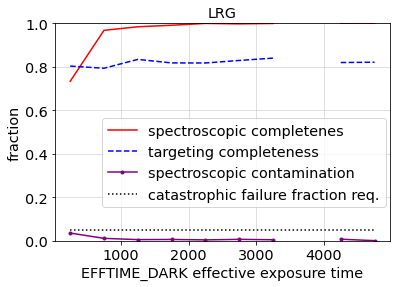

the target redshift range is 0.4<z<1.0
spectroscopic completeness is defined as the fraction of redshifts obained within the target range that have no zwarn flag, divided by the number of true redshifts within the target range (it does not exclude catastrophic failures)
targeting completeness is defined as the fraction of targets with true redshifts within the target range, divided by the total number of targets; variations are only due to variations in target properties in different tiles
spectroscopic contamination is defined as the fraction of redshifts, within the target range and with no zwarn flag, that are further than 0.0033(1+z_truth) from z_truth (cutting to the target redshift range and to zwarn == 0 in both numerator and denominator)


In [32]:
evalSR.effvsdepth(tf,'LRG',nbin=10,lplace=(.12,.12),depth='EFFTIME_DARK')

/global/u2/a/ajross/LSS/Sandbox/evalSR.py:161: RuntimeWarning: invalid value encountered in true_divide
  plt.plot(hv,b[0]/a[0],'k-',label='cumulative fraction not catastrophic')


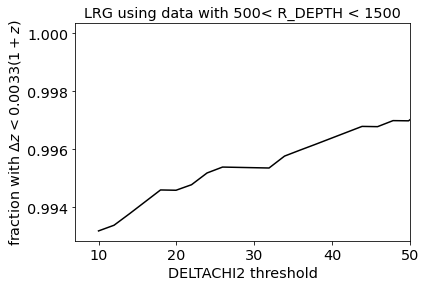

In [31]:
evalSR.repeatvsdchi2(tf,'LRG')

In [33]:
tf = evalSR.add_truth('ELG',release='cascades',version='3',bdir='/global/cfs/cdirs/desi/survey/catalogs/SV1/redshift_comps')

Using the SV1 ELG_FDR_GTOT selection
fraction of targets in nominal selection is 0.3844257848064955
number of unique targets is 39405


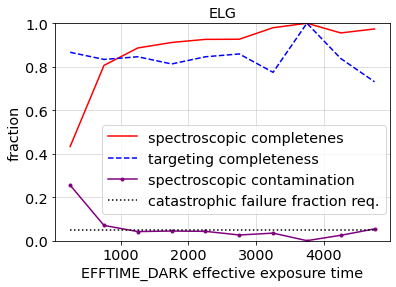

the target redshift range is 0.6<z<1.6
spectroscopic completeness is defined as the fraction of redshifts obained within the target range that have no zwarn flag, divided by the number of true redshifts within the target range (it does not exclude catastrophic failures)
targeting completeness is defined as the fraction of targets with true redshifts within the target range, divided by the total number of targets; variations are only due to variations in target properties in different tiles
spectroscopic contamination is defined as the fraction of redshifts, within the target range and with no zwarn flag, that are further than 0.0033(1+z_truth) from z_truth (cutting to the target redshift range and to zwarn == 0 in both numerator and denominator)


In [34]:
evalSR.effvsdepth(tf,'ELG',nbin=10,lplace=(.12,.09),depth='EFFTIME_DARK')

/global/u2/a/ajross/LSS/Sandbox/evalSR.py:113: RuntimeWarning: invalid value encountered in true_divide
  plt.plot(hv,c[0]/e[0],'r-',label='spectroscopic completenes')
/global/u2/a/ajross/LSS/Sandbox/evalSR.py:115: RuntimeWarning: invalid value encountered in true_divide
  plt.plot(hv,d[0]/c[0],'.-',color='purple',label= 'spectroscopic contamination' )


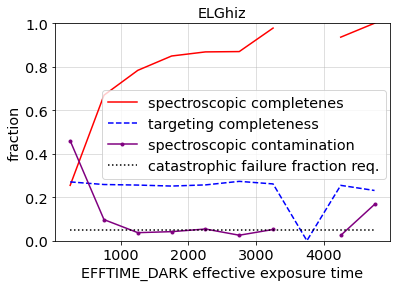

the target redshift range is 1.2<z<1.6
spectroscopic completeness is defined as the fraction of redshifts obained within the target range that have no zwarn flag, divided by the number of true redshifts within the target range (it does not exclude catastrophic failures)
targeting completeness is defined as the fraction of targets with true redshifts within the target range, divided by the total number of targets; variations are only due to variations in target properties in different tiles
spectroscopic contamination is defined as the fraction of redshifts, within the target range and with no zwarn flag, that are further than 0.0033(1+z_truth) from z_truth (cutting to the target redshift range and to zwarn == 0 in both numerator and denominator)


In [35]:
evalSR.effvsdepth(tf,'ELGhiz',nbin=10,lplace=(.12,.25),depth='EFFTIME_DARK')

/global/u2/a/ajross/LSS/Sandbox/evalSR.py:161: RuntimeWarning: invalid value encountered in true_divide
  plt.plot(hv,b[0]/a[0],'k-',label='cumulative fraction not catastrophic')


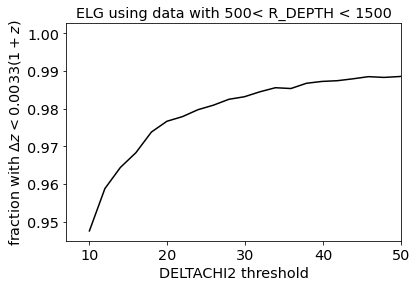

In [36]:
evalSR.repeatvsdchi2(tf,'ELG')

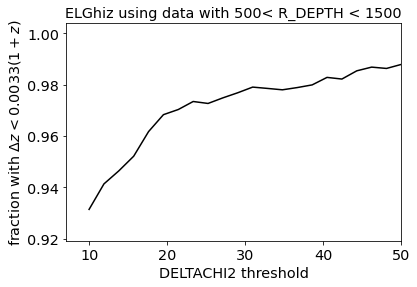

In [37]:
evalSR.repeatvsdchi2(tf,'ELGhiz',rng=(9,200),nbin=100)

/global/u2/a/ajross/LSS/Sandbox/evalSR.py:161: RuntimeWarning: invalid value encountered in true_divide
  plt.plot(hv,b[0]/a[0],'k-',label='cumulative fraction not catastrophic')


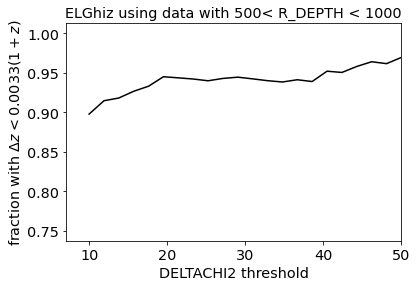

In [38]:
evalSR.repeatvsdchi2(tf,'ELGhiz',rng=(9,200),nbin=100,maxd=1000)

In [39]:
tf = evalSR.add_truth('QSO',release='cascades',version='3',bdir='/global/cfs/cdirs/desi/survey/catalogs/SV1/redshift_comps')

Using the SV1 QSO_RF_4PASS selection
fraction of targets in nominal selection is 0.45105976104399964
number of unique targets is 25937


/global/u2/a/ajross/LSS/Sandbox/evalSR.py:113: RuntimeWarning: invalid value encountered in true_divide
  plt.plot(hv,c[0]/e[0],'r-',label='spectroscopic completenes')
/global/u2/a/ajross/LSS/Sandbox/evalSR.py:114: RuntimeWarning: invalid value encountered in true_divide
  plt.plot(hv,e[0]/a[0],'b--',label='targeting completeness' )
/global/u2/a/ajross/LSS/Sandbox/evalSR.py:115: RuntimeWarning: invalid value encountered in true_divide
  plt.plot(hv,d[0]/c[0],'.-',color='purple',label= 'spectroscopic contamination' )


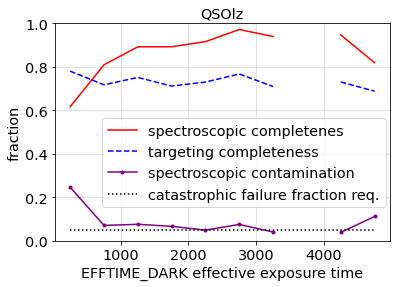

the target redshift range is 0.6<z<2.1
spectroscopic completeness is defined as the fraction of redshifts obained within the target range that have no zwarn flag, divided by the number of true redshifts within the target range (it does not exclude catastrophic failures)
targeting completeness is defined as the fraction of targets with true redshifts within the target range, divided by the total number of targets; variations are only due to variations in target properties in different tiles
spectroscopic contamination is defined as the fraction of redshifts, within the target range and with no zwarn flag, that are further than 0.0033(1+z_truth) from z_truth (cutting to the target redshift range and to zwarn == 0 in both numerator and denominator)


In [40]:
evalSR.effvsdepth(tf,'QSOlz',nbin=10,lplace=(.12,.12),depth='EFFTIME_DARK')

/global/u2/a/ajross/LSS/Sandbox/evalSR.py:113: RuntimeWarning: invalid value encountered in true_divide
  plt.plot(hv,c[0]/e[0],'r-',label='spectroscopic completenes')
/global/u2/a/ajross/LSS/Sandbox/evalSR.py:114: RuntimeWarning: invalid value encountered in true_divide
  plt.plot(hv,e[0]/a[0],'b--',label='targeting completeness' )
/global/u2/a/ajross/LSS/Sandbox/evalSR.py:115: RuntimeWarning: invalid value encountered in true_divide
  plt.plot(hv,d[0]/c[0],'.-',color='purple',label= 'spectroscopic contamination' )


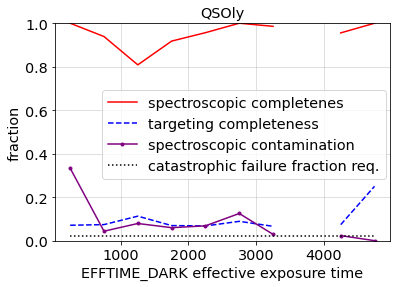

the target redshift range is 2.1<z<4.5
spectroscopic completeness is defined as the fraction of redshifts obained within the target range that have no zwarn flag, divided by the number of true redshifts within the target range (it does not exclude catastrophic failures)
targeting completeness is defined as the fraction of targets with true redshifts within the target range, divided by the total number of targets; variations are only due to variations in target properties in different tiles
spectroscopic contamination is defined as the fraction of redshifts, within the target range and with no zwarn flag, that are further than 0.0033(1+z_truth) from z_truth (cutting to the target redshift range and to zwarn == 0 in both numerator and denominator)


In [41]:
evalSR.effvsdepth(tf,'QSOly',nbin=10,lplace=(.12,.25),depth='EFFTIME_DARK')

In [119]:
tf = evalSR.add_truth('BGS_ANY')

Using the SV1 BGS_ANY selection
fraction of targets in nominal selection is 1.0
number of unique targets is 27272


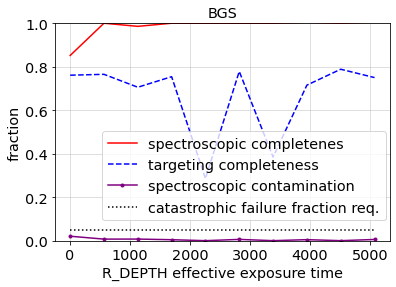

the target redshift range is 0.01<z<0.5
spectroscopic completeness is defined as the fraction of redshifts obained within the target range that have no zwarn flag, divided by the number of true redshifts within the target range (it does not exclude catastrophic failures)
targeting completeness is defined as the fraction of targets with true redshifts within the target range, divided by the total number of targets; variations are only due to variations in target properties in different tiles
spectroscopic contamination is defined as the fraction of redshifts, within the target range and with no zwarn flag, that are further than 0.0033(1+z_truth) from z_truth (cutting to the target redshift range and to zwarn == 0 in both numerator and denominator)


In [120]:
evalSR.effvsdepth(tf,'BGS',nbin=10,lplace=(.12,.06))

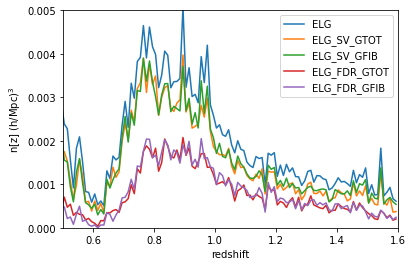

In [136]:
for subt in ['ELG', 'ELG_SV_GTOT', 'ELG_SV_GFIB', 'ELG_FDR_GTOT', 'ELG_FDR_GFIB']:
    d = np.loadtxt('/global/cfs/cdirs/desi/survey/catalogs/SV1/LSS/LSScats/v0/'+subt+'alltiles_deep_nz.dat').transpose()
    plt.plot(d[0],d[3],label=subt)
plt.xlim(0.5,1.6)
plt.ylim(0,.005)
plt.xlabel('redshift')
plt.ylabel(r'n[z] (h/Mpc)$^3$')
plt.legend()
plt.show()    

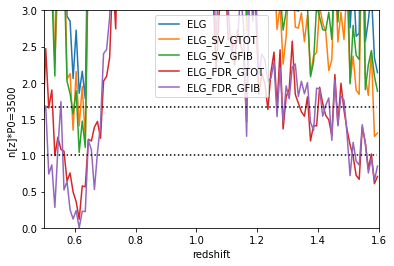

In [137]:
P0 = 3500
for subt in ['ELG', 'ELG_SV_GTOT', 'ELG_SV_GFIB', 'ELG_FDR_GTOT', 'ELG_FDR_GFIB']:
    d = np.loadtxt('/global/cfs/cdirs/desi/survey/catalogs/SV1/LSS/LSScats/v0/'+subt+'alltiles_deep_nz.dat').transpose()
    plt.plot(d[0],d[3]*P0,label=subt)
ol = np.ones(len(d[0]))
plt.plot(d[0],ol,'k:')
plt.plot(d[0],ol*3500/2100,'k:')
plt.xlim(0.5,1.6)
plt.ylim(0,3)
plt.xlabel('redshift')
plt.ylabel(r'n[z]*P0=3500 ')
plt.legend()
plt.show()    

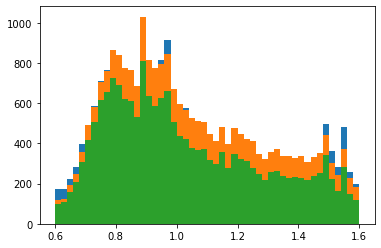

In [290]:
plt.hist(fu['Z'],weights=fu['elgqso_weight'],range=(0.6,1.6),bins=50)
plt.hist(fu['Z'][wz],range=(0.6,1.6),bins=50)
plt.hist(fu['Z'][wz],weights=fu['elgqso_weight'][wz],range=(0.6,1.6),bins=50)
plt.show()

In [341]:
wz = fu['ZWARN'] == 0
wz &= fu['FIBERSTATUS'] == 0

In [342]:
fuz = fu[wz]

In [291]:
R_G=3.214 # http://legacysurvey.org/dr8/catalogs/#galactic-extinction-coefficients
R_R=2.165
R_Z=1.211

In [331]:
ge = fgf['FLUX_G']*10.**(-0.4*R_G*fgf['EBV'])
gef = fgf['FIBERFLUX_G']*10.**(-0.4*R_G*fgf['EBV'])
gfib = 22.5-2.5*np.log10(fgf['FIBERFLUX_G'])-R_G*fgf['EBV']
gfibt = 22.5-2.5*np.log10(fgf['FIBERTOTFLUX_G'])-R_G*fgf['EBV']

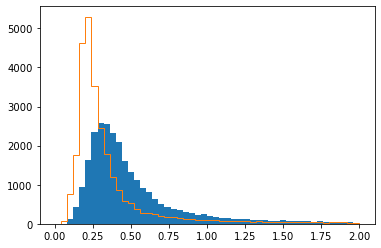

(array([2.580e+02, 2.600e+02, 2.860e+02, 3.200e+02, 3.050e+02, 3.510e+02,
        3.810e+02, 4.510e+02, 4.710e+02, 5.220e+02, 5.560e+02, 5.590e+02,
        6.690e+02, 6.970e+02, 7.530e+02, 7.650e+02, 8.340e+02, 8.930e+02,
        8.500e+02, 9.210e+02, 9.870e+02, 1.072e+03, 1.129e+03, 1.178e+03,
        1.238e+03, 1.256e+03, 1.259e+03, 1.105e+03, 9.460e+02, 5.800e+02,
        3.450e+02, 1.990e+02, 1.120e+02, 6.800e+01, 4.600e+01, 3.300e+01,
        1.400e+01, 1.000e+01, 1.400e+01, 6.000e+00, 8.000e+00, 3.000e+00,
        5.000e+00, 3.000e+00, 1.000e+00, 1.000e+00, 4.000e+00, 2.000e+00,
        1.000e+00, 3.000e+00]),
 array([23.  , 23.04, 23.08, 23.12, 23.16, 23.2 , 23.24, 23.28, 23.32,
        23.36, 23.4 , 23.44, 23.48, 23.52, 23.56, 23.6 , 23.64, 23.68,
        23.72, 23.76, 23.8 , 23.84, 23.88, 23.92, 23.96, 24.  , 24.04,
        24.08, 24.12, 24.16, 24.2 , 24.24, 24.28, 24.32, 24.36, 24.4 ,
        24.44, 24.48, 24.52, 24.56, 24.6 , 24.64, 24.68, 24.72, 24.76,
        24.8 , 24.84,

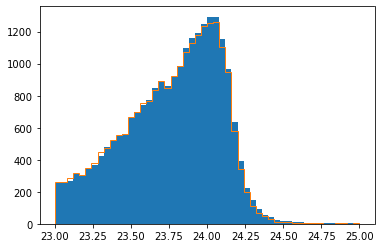

In [332]:
plt.hist(ge,range=(0,2),bins=50)
plt.hist(gef,range=(0,2),bins=50,histtype='step')
plt.show()
plt.hist(gfib,range=(23,25),bins=50)
plt.hist(gfibt,histtype='step',range=(23,25),bins=50)

In [324]:
np.max(gfib)
wgg = gfib > 24.1
print(len(gfib[wgg])/len(gfib))
wgg = gfibt > 24.1
print(len(gfib[wgg])/len(gfib))

0.11434101706844976
0.1035368643322189


In [366]:
wgf = (fu['SV1_DESI_TARGET'] & sv1_targetmask.desi_mask['ELG_SV_GFIB']) > 0
wgff = (fu['SV1_DESI_TARGET'] & sv1_targetmask.desi_mask['ELG_FDR_GFIB']) > 0
fgf = fu[wgf]
fgff = fu[wgff]
print(np.sum(fgff['elgqso_weight'])/np.sum(fgf['elgqso_weight']))

0.439703380480605


0.43911639346181 0.439703380480605
0.6155851078900396 0.6807838992538735


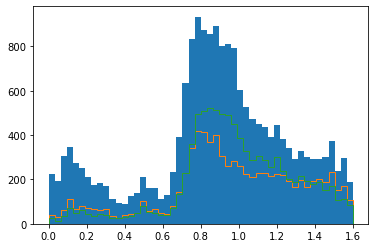

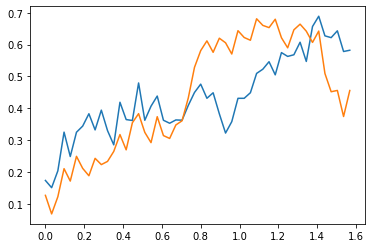

In [428]:
#wgl = (fgf['gmr'] < 0.3) #& (fgf['gmr'] < 1.15*fgf['rmz'])
wgl = (fgf['gmr'] < 1.15*fgf['rmz']-0.15)
wgl &= fgf['rmz'] < .77
wgl &= fgf['gfibmag'] < 24.3

wz = fgf['ZWARN'] == 0
wz &= fgf['FIBERSTATUS'] == 0
wglt = wz & wgl
wzf = fgff['ZWARN'] == 0
wzf &= fgff['FIBERSTATUS'] == 0
print(np.sum(fgf[wgl]['elgqso_weight'])/np.sum(fgf['elgqso_weight']),np.sum(fgff['elgqso_weight'])/np.sum(fgf['elgqso_weight']))
print(np.sum(fgf[wglt]['elgqso_weight'])/np.sum(fgf[wgl]['elgqso_weight']),np.sum(fgff[wzf]['elgqso_weight'])/np.sum(fgff['elgqso_weight']))
a = plt.hist(fgf['Z'][wz],weights=fgf['elgqso_weight'][wz],range=(0,1.6),bins=50)
b = plt.hist(fgf['Z'][wglt],weights=fgf['elgqso_weight'][wglt],range=(0,1.6),bins=50,histtype='step')
c = plt.hist(fgff['Z'][wzf],weights=fgff['elgqso_weight'][wzf],range=(0,1.6),bins=50,histtype='step')
plt.show()
plt.plot(a[1][:-1],b[0]/a[0])
plt.plot(a[1][:-1],c[0]/a[0])
plt.show()

In [431]:
wz = fgf['ZWARN'] == 0
wz &= fgf['FIBERSTATUS'] == 0
#wz &= fgf['Z'] > 1.5
#wz &= fgf['Z'] < 1.6

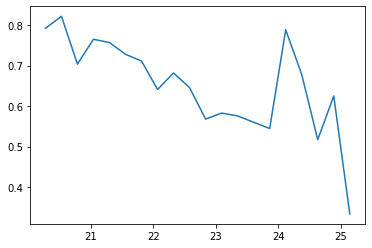

In [437]:
a = plt.hist(fgf['gfibmag'],weights=fgf['elgqso_weight'],bins=20)
b = plt.hist(fgf['gfibmag'][wz],weights=fgf['elgqso_weight'][wz],bins=20)
plt.clf()
plt.plot(a[1][:-1],b[0]/a[0])
plt.show()

(array([4.41556478e-04, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 1.47185493e-04, 0.00000000e+00, 1.47185493e-04,
        1.47185493e-04, 2.94370985e-04, 0.00000000e+00, 2.94370985e-04,
        1.47185786e-04, 2.94370985e-04, 1.47185786e-04, 4.41556478e-04,
        5.88743145e-04, 8.83112956e-04, 7.35927463e-04, 5.88743145e-04,
        1.17748394e-03, 8.83114717e-04, 1.17748394e-03, 1.17748629e-03,
        1.03029845e-03, 7.35928197e-04, 1.32467076e-03, 2.94371279e-03,
        2.35497023e-03, 3.09089843e-03, 1.76622767e-03, 5.00430675e-03,
        8.53676709e-03, 7.65365707e-03, 1.00086185e-02, 1.17748512e-02,
        1.76622767e-02, 2.63462229e-02, 3.60604817e-02, 4.84240693e-02,
        7.38871818e-02, 1.54397717e-01, 3.17332199e-01, 4.28163025e-01,
        5.40759905e-01, 6.42318131e-01, 6.60569150e-01, 5.51798687e-01,
        3.79003022e-01, 2.39618221e-01]),
 array([-9.95542   , -9.716315  , -9.477211  , -9.238108  , -8.999003  ,
        -8.759899  , 

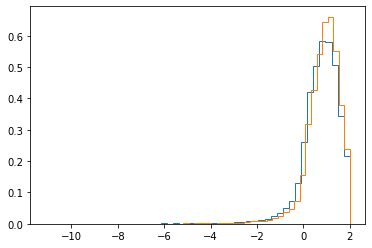

In [429]:
plt.hist(fgf['coii'],histtype='step',density=True,bins=50)#,range=(-2,2))
plt.hist(fgf[wz]['coii'],density=True,bins=50,histtype='step')#,range=(-2,2))

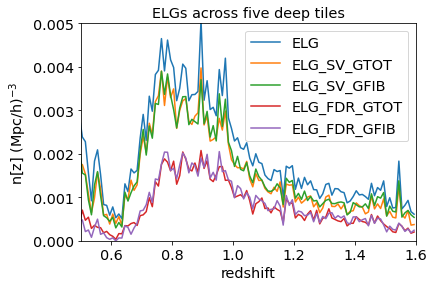

In [580]:
for subt in ['ELG','ELG_SV_GTOT', 'ELG_SV_GFIB', 'ELG_FDR_GTOT', 'ELG_FDR_GFIB']:
    d = np.loadtxt('/global/cfs/cdirs/desi/survey/catalogs/SV1/LSS/LSScats/v0/'+subt+'alltiles_deep_nz.dat').transpose()
    plt.plot(d[0],d[3],label=subt)
plt.xlim(0.5,1.6)
plt.ylim(0,0.005)
plt.xlabel('redshift')
plt.ylabel(r'n[z] (Mpc/h)$^{-3}$')
plt.legend()
plt.title('ELGs across five deep tiles')
plt.show()    

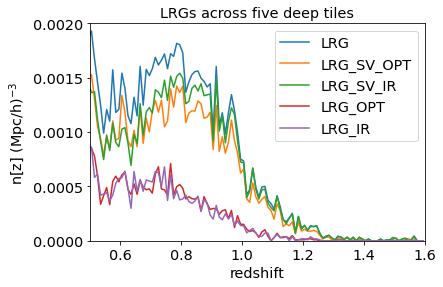

In [582]:
for subt in ['LRG','LRG_SV_OPT', 'LRG_SV_IR', 'LRG_OPT', 'LRG_IR']:
    d = np.loadtxt('/global/cfs/cdirs/desi/survey/catalogs/SV1/LSS/LSScats/v0/'+subt+'alltiles_deep_nz.dat').transpose()
    plt.plot(d[0],d[3],label=subt)
plt.xlim(0.5,1.6)
plt.ylim(0,0.002)
plt.xlabel('redshift')
plt.ylabel(r'n[z] (Mpc/h)$^{-3}$')
plt.legend()
plt.title('LRGs across five deep tiles')
plt.show()    

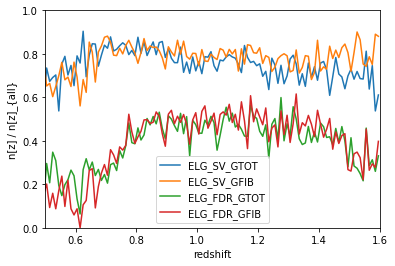

In [304]:
da = np.loadtxt('/global/cfs/cdirs/desi/survey/catalogs/SV1/LSS/LSScats/v0/ELGalltiles_deep_nz.dat').transpose()
for subt in ['ELG_SV_GTOT', 'ELG_SV_GFIB', 'ELG_FDR_GTOT', 'ELG_FDR_GFIB']:
    d = np.loadtxt('/global/cfs/cdirs/desi/survey/catalogs/SV1/LSS/LSScats/v0/'+subt+'alltiles_deep_nz.dat').transpose()
    plt.plot(d[0],d[3]/da[3],label=subt)
plt.xlim(0.5,1.6)
plt.ylim(0,1)
plt.xlabel('redshift')
plt.ylabel(r'n[z] / n[z]_{all}')
plt.legend()
plt.show()    

In [262]:
f.dtype.names

('TARGETID',
 'CHI2',
 'COEFF',
 'Z',
 'ZERR',
 'ZWARN',
 'NPIXELS',
 'SPECTYPE',
 'SUBTYPE',
 'NCOEFF',
 'DELTACHI2',
 'NUMEXP',
 'NUMTILE',
 'PETAL_LOC',
 'DEVICE_LOC',
 'LOCATION',
 'FIBER',
 'FIBERSTATUS',
 'TARGET_RA',
 'TARGET_DEC',
 'PMRA',
 'PMDEC',
 'REF_EPOCH',
 'LAMBDA_REF',
 'FA_TARGET',
 'FA_TYPE',
 'OBJTYPE',
 'FIBERASSIGN_X',
 'FIBERASSIGN_Y',
 'NUMTARGET',
 'PRIORITY',
 'SUBPRIORITY',
 'OBSCONDITIONS',
 'MORPHTYPE',
 'FLUX_G',
 'FLUX_R',
 'FLUX_Z',
 'FLUX_IVAR_G',
 'FLUX_IVAR_R',
 'FLUX_IVAR_Z',
 'REF_ID',
 'REF_CAT',
 'GAIA_PHOT_G_MEAN_MAG',
 'GAIA_PHOT_BP_MEAN_MAG',
 'GAIA_PHOT_RP_MEAN_MAG',
 'PARALLAX',
 'EBV',
 'FLUX_W1',
 'FLUX_W2',
 'FIBERFLUX_G',
 'FIBERFLUX_R',
 'FIBERFLUX_Z',
 'FIBERTOTFLUX_G',
 'FIBERTOTFLUX_R',
 'FIBERTOTFLUX_Z',
 'MASKBITS',
 'SERSIC',
 'SHAPE_R',
 'SHAPE_E1',
 'SHAPE_E2',
 'PHOTSYS',
 'SV1_DESI_TARGET',
 'SV1_BGS_TARGET',
 'SV1_MWS_TARGET',
 'PRIORITY_INIT',
 'NUMOBS_INIT',
 'RELEASE',
 'BRICKID',
 'BRICKNAME',
 'BRICK_OBJID',
 'BLOBDIST',


In [266]:
np.unique(f['EXPS'])

array(['67968,67969,67970,67971', '67972,67973,67974,67975,67987',
       '68013,68023,68024,68025,68026', '68027,68028',
       '68039,68040,68041,68042', '68063,68064,68065',
       '68284,68285,68288,68289', '68290,68291,68292',
       '68317,68327,68328', '68330,68331,68332,68333',
       '68334,68336,68337,68338,68339,68340', '68477,68478,68488',
       '68489,68490', '68491,68492', '68619', '68630',
       '68644,68645,68646', '68657,68658,68659', '68660,68661',
       '68662,68663,68664', '68662,68663,68664,68666',
       '68672,68673,68674', '68675,68676,68677', '68678,68681,68682',
       '68683', '68684,68685,68686', '68790,68794,68795,68796,68797',
       '68799,68800,68801', '68812,68813', '68824,68825,68826',
       '68837,68838,68839', '68841,68842', '68844,68845,68846,68847',
       '68849,68850,68851', '68853,68854,68856', '68858,68859,68879',
       '68890', '68890,68892', '68903',
       '69016,69017,69018,69019,69020,69021,69022',
       '69024,69025,69026,69027,6902

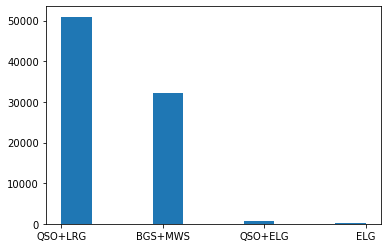

In [270]:
plt.hist(f['TARGETS'])
#plt.hist(f['Z_DEPTH_EBVAIR'])
plt.show()

In [253]:
expids = np.unique(f['EXPID'])

In [254]:
expids_str = ",".join(expids.astype(str))

In [255]:
expids_str

'69031,69212,69407'

In [259]:
np.unique(f['EXPS'])

array(['67710,67711,67712,67713',
       '67710,67711,67712,67713,67972,67973,67974,67975,67987,68290,68291,68292',
       '67972,67973,67974,67975,67987', '67972,67975,68290,68291,68292',
       '68290,68291,68292'], dtype='<U71')

In [275]:
np.min(f['COADD_EXPTIME'])

0.0

In [392]:
f = fitsio.read('/global/cscratch1/sd/mjwilson/desi/tsnr/summary_b0.fits')

In [393]:
f.dtype.names

('EXPID',
 'NIGHT',
 'CAMERA',
 'ALPHA',
 'ELGTSNR',
 'BGSTSNR',
 'QSOTSNR',
 'LRGTSNR')

In [394]:
np.unique(f['CAMERA'])

array(['b0'], dtype='<U2')

In [438]:
import pandas as pd

In [440]:
dir = '/global/cfs/cdirs/desi/sv/vi/TruthTables/Blanc/'
t=Table.read(dir+'ELG/'+'desi-vi_ELG_tile80608_nightdeep_merged_all_210203.csv',format='pandas.csv')

In [445]:
tz = Table.read('/global/cfs/cdirs/desi/survey/catalogs/SV1/redshift_comps/blanc/v1/ELG/80608_ELGzinfo.fits')

In [446]:
len(tz)

43958

In [447]:
wd = tz['subset'] == 'deep'

In [448]:
td = tz[wd]

In [449]:
len(td)

4070

In [450]:
wf = td['FIBERSTATUS'] == 0

In [451]:
len(td[wf])

3430

In [452]:
len(t)

3380

In [460]:
t.keep_columns(['TARGETID','best_z','best_quality','best_spectype','all_VI_issues','all_VI_comments','merger_comment','N_VI'])

In [461]:
t.columns

<TableColumns names=('TARGETID','best_z','best_quality','best_spectype','all_VI_issues','all_VI_comments','merger_comment','N_VI')>

In [463]:
from astropy.table import join

In [465]:
tj = join(td,t,join_type='left',keys='TARGETID')

In [466]:
len(tj)

4070

In [467]:
tj.columns

<TableColumns names=('TARGETID','CHI2','COEFF','Z','ZERR','ZWARN','NPIXELS','SPECTYPE','SUBTYPE','NCOEFF','DELTACHI2','NUMEXP','NUMTILE','PETAL_LOC','DEVICE_LOC','LOCATION','FIBER','FIBERSTATUS','TARGET_RA','TARGET_DEC','PMRA','PMDEC','REF_EPOCH','LAMBDA_REF','FA_TARGET','FA_TYPE','OBJTYPE','FIBERASSIGN_X','FIBERASSIGN_Y','NUMTARGET','PRIORITY','SUBPRIORITY','OBSCONDITIONS','MORPHTYPE','FLUX_G','FLUX_R','FLUX_Z','FLUX_IVAR_G','FLUX_IVAR_R','FLUX_IVAR_Z','REF_ID','REF_CAT','GAIA_PHOT_G_MEAN_MAG','GAIA_PHOT_BP_MEAN_MAG','GAIA_PHOT_RP_MEAN_MAG','PARALLAX','EBV','FLUX_W1','FLUX_W2','FIBERFLUX_G','FIBERFLUX_R','FIBERFLUX_Z','FIBERTOTFLUX_G','FIBERTOTFLUX_R','FIBERTOTFLUX_Z','MASKBITS','SERSIC','SHAPE_R','SHAPE_E1','SHAPE_E2','PHOTSYS','SV1_DESI_TARGET','SV1_BGS_TARGET','SV1_MWS_TARGET','PRIORITY_INIT','NUMOBS_INIT','RELEASE','BRICKID','BRICKNAME','BRICK_OBJID','BLOBDIST','FIBERFLUX_IVAR_G','FIBERFLUX_IVAR_R','FIBERFLUX_IVAR_Z','DESI_TARGET','BGS_TARGET','MWS_TARGET','HPXPIXEL','NUM_ITER','F

In [469]:
np.unique(tj['all_VI_issues'])

C
CR
CS
--
R
RC
RCS
RS
RSC
S
SC


In [477]:
tj.write('test.fits',format='fits',overwrite=True,fill_values=[(tj.masked, np.nan)])

TypeError: write_table_fits() got an unexpected keyword argument 'fill_values'

In [471]:
f = fitsio.read('test.fits')

In [478]:
tj.masked

False

In [472]:
f.dtype.names

('TARGETID',
 'CHI2',
 'COEFF',
 'Z',
 'ZERR',
 'ZWARN',
 'NPIXELS',
 'SPECTYPE',
 'SUBTYPE',
 'NCOEFF',
 'DELTACHI2',
 'NUMEXP',
 'NUMTILE',
 'PETAL_LOC',
 'DEVICE_LOC',
 'LOCATION',
 'FIBER',
 'FIBERSTATUS',
 'TARGET_RA',
 'TARGET_DEC',
 'PMRA',
 'PMDEC',
 'REF_EPOCH',
 'LAMBDA_REF',
 'FA_TARGET',
 'FA_TYPE',
 'OBJTYPE',
 'FIBERASSIGN_X',
 'FIBERASSIGN_Y',
 'NUMTARGET',
 'PRIORITY',
 'SUBPRIORITY',
 'OBSCONDITIONS',
 'MORPHTYPE',
 'FLUX_G',
 'FLUX_R',
 'FLUX_Z',
 'FLUX_IVAR_G',
 'FLUX_IVAR_R',
 'FLUX_IVAR_Z',
 'REF_ID',
 'REF_CAT',
 'GAIA_PHOT_G_MEAN_MAG',
 'GAIA_PHOT_BP_MEAN_MAG',
 'GAIA_PHOT_RP_MEAN_MAG',
 'PARALLAX',
 'EBV',
 'FLUX_W1',
 'FLUX_W2',
 'FIBERFLUX_G',
 'FIBERFLUX_R',
 'FIBERFLUX_Z',
 'FIBERTOTFLUX_G',
 'FIBERTOTFLUX_R',
 'FIBERTOTFLUX_Z',
 'MASKBITS',
 'SERSIC',
 'SHAPE_R',
 'SHAPE_E1',
 'SHAPE_E2',
 'PHOTSYS',
 'SV1_DESI_TARGET',
 'SV1_BGS_TARGET',
 'SV1_MWS_TARGET',
 'PRIORITY_INIT',
 'NUMOBS_INIT',
 'RELEASE',
 'BRICKID',
 'BRICKNAME',
 'BRICK_OBJID',
 'BLOBDIST',


In [480]:
tj['best_quality'].masked = np.nan

In [475]:
np.max(f['best_z'])

1e+20

In [493]:
np.unique(tj['best_quality'])

-999.0
0.0
0.3333333333333333
0.5
0.6666666666666666
1.0
1.3333333333333333
1.5
2.0
2.333333333333333
2.5


In [482]:
len(tj['best_quality'].masked)

TypeError: object of type 'float' has no len()

In [500]:
tj['N_VI'].fill_value = 0

In [494]:
tj['best_z'] = tj['best_z'].filled()

In [497]:
np.min(tj['best_quality'])

-999.0

In [502]:
np.unique(tj['N_VI'].filled())

0
1
2
3
4


In [503]:
w = tj['N_VI'].filled() > 0
np.unique(tj['best_quality'][w])

0.0
0.3333333333333333
0.5
0.6666666666666666
1.0
1.3333333333333333
1.5
2.0
2.333333333333333
2.5
2.6666666666666665


In [519]:
f = fitsio.read('/global/cfs/cdirs/desi/survey/catalogs/SV1/redshift_comps/blanc/v1//ELG/80608_ELGzinfo_wVI.fits')

In [516]:
len(f)

43958

In [520]:
wd = f['subset'] == 'deep'
fd = f[wd]

In [533]:
wz = fd['ZWARN'] == 0
wz &= fd['FIBERSTATUS'] == 0
wz &= fd['DELTACHI2'] > 100
wz &= fd['Z'] > 0.6
wz &= fd['Z'] < 1.6
wz &= fd['N_VI'] > 0
print(len(fd[wz]))

1972


In [530]:
np.unique(fd[wz]['N_VI'])

array([0, 1, 2, 3, 4])

In [534]:
fz = fd[wz]

In [532]:
wv = fz['N_VI'] > 0
print(len(fz[wv]))

1972


In [535]:
np.unique(fz['best_quality'])

array([0.        , 0.5       , 0.66666667, 1.        , 1.33333333,
       1.5       , 2.        , 2.33333333, 2.5       , 2.66666667,
       3.        , 3.33333333, 3.5       , 3.66666667, 4.        ])

In [528]:
wva = fd['N_VI'] == 0
wva &= fd['FIBERSTATUS'] == 0
print(len(fd[wva]))

50


(0.7, 1.0)

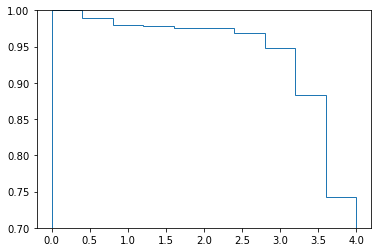

In [541]:
plt.hist(fz['best_quality'],range=(0,4),cumulative=-1,density=True,histtype='step')
plt.ylim(.7,1)

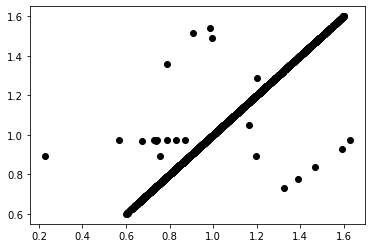

In [542]:
plt.plot(fz['best_z'],fz['Z'],'ko')

(-0.02, 0.02)

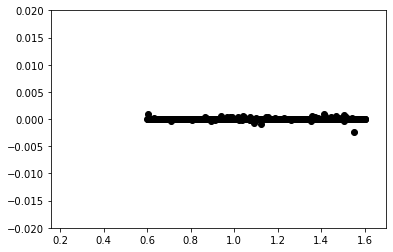

In [544]:
plt.plot(fz['best_z'],fz['best_z']-fz['Z'],'ko')
plt.ylim(-0.02,.02)

In [547]:
wb = abs(fz['best_z']-fz['Z']) > 0.005
len(fz[wb])/len(fz)

0.011156186612576065

In [548]:
band = 'b'
spec = 0
cinfo = fitsio.read('/global/cscratch1/sd/mjwilson/desi/tsnr/summary_'+band+str(spec)+'.fits')

In [549]:
info = cinfo[cinfo['EXPID'] == 67769]  

<ipython-input-549-71701b153eb3>:1: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  info = cinfo[cinfo['EXPID'] == 67769]


In [551]:
info['ELGTSNR']

array([], shape=(0, 286), dtype=float32)

In [552]:
np.unique(cinfo['EXPID'])

array(['00067733', '00067744', '00067765', '00067766', '00067767',
       '00067768', '00067769', '00067770', '00067771', '00067781',
       '00067782', '00067783', '00067784', '00067968', '00067969',
       '00067970', '00067971', '00067972', '00067973', '00067974',
       '00067975', '00067987', '00068013', '00068023', '00068024',
       '00068025', '00068026', '00068027', '00068028', '00068039',
       '00068040', '00068041', '00068042', '00068063', '00068064',
       '00068065', '00068265', '00068266', '00068272', '00068273',
       '00068284', '00068285', '00068288', '00068289', '00068290',
       '00068291', '00068292', '00068317', '00068327', '00068328',
       '00068330', '00068331', '00068332', '00068333', '00068334',
       '00068336', '00068337', '00068338', '00068339', '00068340',
       '00068477', '00068478', '00068488', '00068489', '00068490',
       '00068491', '00068492', '00068619', '00068630', '00068644',
       '00068645', '00068646', '00068657', '00068658', '000686

total number, total deep, min depth for deep
179361 27012 10195.096465349197
number of unique targets is 26051
26232
number, fraction of failures, fraction of failures with zwarn==0
20481 0.15707240857380012 0.09320833943655095


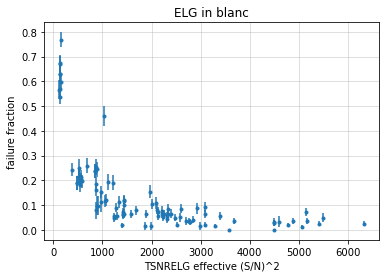

In [560]:
tp = 'ELG'
release = 'blanc'
version = 'testsnr'
bdir = '/global/cscratch1/sd/ajross/SV1/redshift_comps'
deep_dchi2 = 100

f = fitsio.read(bdir+'/'+release+'/'+version+'/'+tp+'/alltiles_'+tp+'zinfo.fits') #fitsio *much* faster than using Table here
deep = f[f['subset']=='deep'] 
min_depth = np.max(deep[tp+'TSNR'])/2

print('total number, total deep, min depth for deep')
print(len(f),len(deep),min_depth)
#get list of truez in appropriate rows, matching Rongpu's definition for criteria required to allow truth determination
#rows without truth have z==0
mzl = np.zeros(len(f))
tids = np.unique(f['TARGETID'])
print('number of unique targets is '+str(len(tids)))
for iid in tids:
    sf = f['TARGETID'] == iid
    fi = f[sf]
    fd = fi[fi['subset']=='deep']
    mask = fd['FIBERSTATUS']==0 # Remove FIBERSTATUS!=0 fibers
    mask &= fd['ZWARN'] & 2**9==0 # Remove "no data" fibers
    mask &= fd['ZWARN']==0
    mask &= fd[tp+'TSNR'] > min_depth
    mask &= fd['DELTACHI2'] > deep_dchi2
    if len(fd[mask]) > 0:
        mzl[sf] = fd['Z'][0]

w = mzl != 0
print(len(mzl[w]))
tf = Table(f)
tf['Z_TRUTH'] = mzl
masknight = tf['subset'] != 'deep'
masknight &= tf['subset'] != 'all'
masknight &= tf['Z_TRUTH'] != 0
masknight &= tf['FIBERSTATUS']==0
masknight &= tf['ZWARN'] & 2**9==0
tcomp = tf[masknight]
dz = tcomp['Z'] - tcomp['Z_TRUTH']
bz = abs(dz) > fail_threshold
bzz = bz & (tcomp['ZWARN'] != 0)
print('number, fraction of failures, fraction of failures with zwarn==0')
print(len(tcomp),len(tcomp[bz])/len(tcomp),len(tcomp[bzz])/len(tcomp))
rvals = np.unique(tcomp[tp+'TSNR'])
ff = []
rv = []
nb = []
nt = []
for rval in rvals:
    ds = tcomp[tcomp[tp+'TSNR']==rval]
    dz = ds['Z'] - ds['Z_TRUTH']
    bz = abs(dz) > fail_threshold
    if len(ds) > 30 and rval > mindepth:
        ff.append(len(ds[bz])/len(ds))
        nb.append(len(ds[bz]))
        nt.append(len(ds))
        rv.append(rval)
nt = np.array(nt)
nb = np.array(nb)
err = ((nt-nb)*(1.-(nt-nb)/nt))**.5/nt #binomial error formula, needs double-check
plt.errorbar(rv,ff,err,fmt='.')#,label=td)

#plt.legend()
plt.grid(alpha=0.5)
plt.xlabel('TSNR'+tp+' effective (S/N)^2')
plt.ylabel('failure fraction')
plt.title(tp+' in '+release)
plt.show()

In [555]:
f.dtype.names

('TARGETID',
 'CHI2',
 'COEFF',
 'Z',
 'ZERR',
 'ZWARN',
 'NPIXELS',
 'SPECTYPE',
 'SUBTYPE',
 'NCOEFF',
 'DELTACHI2',
 'NUMEXP',
 'NUMTILE',
 'PETAL_LOC',
 'DEVICE_LOC',
 'LOCATION',
 'FIBER',
 'FIBERSTATUS',
 'TARGET_RA',
 'TARGET_DEC',
 'PMRA',
 'PMDEC',
 'REF_EPOCH',
 'LAMBDA_REF',
 'FA_TARGET',
 'FA_TYPE',
 'OBJTYPE',
 'FIBERASSIGN_X',
 'FIBERASSIGN_Y',
 'NUMTARGET',
 'PRIORITY',
 'SUBPRIORITY',
 'OBSCONDITIONS',
 'MORPHTYPE',
 'FLUX_G',
 'FLUX_R',
 'FLUX_Z',
 'FLUX_IVAR_G',
 'FLUX_IVAR_R',
 'FLUX_IVAR_Z',
 'REF_ID',
 'REF_CAT',
 'GAIA_PHOT_G_MEAN_MAG',
 'GAIA_PHOT_BP_MEAN_MAG',
 'GAIA_PHOT_RP_MEAN_MAG',
 'PARALLAX',
 'EBV',
 'FLUX_W1',
 'FLUX_W2',
 'FIBERFLUX_G',
 'FIBERFLUX_R',
 'FIBERFLUX_Z',
 'FIBERTOTFLUX_G',
 'FIBERTOTFLUX_R',
 'FIBERTOTFLUX_Z',
 'MASKBITS',
 'SERSIC',
 'SHAPE_R',
 'SHAPE_E1',
 'SHAPE_E2',
 'PHOTSYS',
 'SV1_DESI_TARGET',
 'SV1_BGS_TARGET',
 'SV1_MWS_TARGET',
 'PRIORITY_INIT',
 'NUMOBS_INIT',
 'RELEASE',
 'BRICKID',
 'BRICKNAME',
 'BRICK_OBJID',
 'BLOBDIST',


In [565]:
import evalSR

In [564]:
os.chdir('/global/u2/a/ajross/LSS/Sandbox')

In [566]:
tf = evalSR.add_truth('ELG',version='testsnr')

Using the SV1 ELG_FDR_GTOT selection
fraction of targets in nominal selection is 0.36238647197551305
number of unique targets is 9504


/global/u2/a/ajross/LSS/Sandbox/evalSR.py:113: RuntimeWarning: invalid value encountered in true_divide
  plt.plot(hv,c[0]/e[0],'r-',label='spectroscopic completenes')
/global/u2/a/ajross/LSS/Sandbox/evalSR.py:114: RuntimeWarning: invalid value encountered in true_divide
  plt.plot(hv,e[0]/a[0],'b--',label='targeting completeness' )
/global/u2/a/ajross/LSS/Sandbox/evalSR.py:115: RuntimeWarning: invalid value encountered in true_divide
  plt.plot(hv,d[0]/c[0],'.-',color='purple',label= 'spectroscopic contamination' )


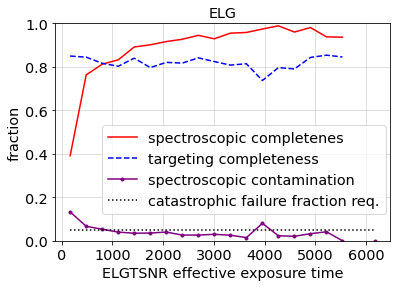

the target redshift range is 0.6<z<1.6
spectroscopic completeness is defined as the fraction of redshifts obained within the target range that have no zwarn flag, divided by the number of true redshifts within the target range (it does not exclude catastrophic failures)
targeting completeness is defined as the fraction of targets with true redshifts within the target range, divided by the total number of targets; variations are only due to variations in target properties in different tiles
spectroscopic contamination is defined as the fraction of redshifts, within the target range and with no zwarn flag, that are further than 0.0033(1+z_truth) from z_truth (cutting to the target redshift range and to zwarn == 0 in both numerator and denominator)


In [570]:
evalSR.effvsdepth(tf,'ELG',nbin=20,lplace=(.12,.09),depth='ELGTSNR')

/global/u2/a/ajross/LSS/Sandbox/evalSR.py:113: RuntimeWarning: invalid value encountered in true_divide
  plt.plot(hv,c[0]/e[0],'r-',label='spectroscopic completenes')
/global/u2/a/ajross/LSS/Sandbox/evalSR.py:114: RuntimeWarning: invalid value encountered in true_divide
  plt.plot(hv,e[0]/a[0],'b--',label='targeting completeness' )
/global/u2/a/ajross/LSS/Sandbox/evalSR.py:115: RuntimeWarning: invalid value encountered in true_divide
  plt.plot(hv,d[0]/c[0],'.-',color='purple',label= 'spectroscopic contamination' )


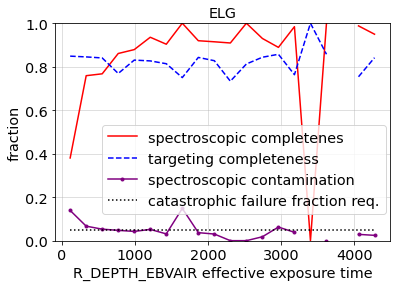

the target redshift range is 0.6<z<1.6
spectroscopic completeness is defined as the fraction of redshifts obained within the target range that have no zwarn flag, divided by the number of true redshifts within the target range (it does not exclude catastrophic failures)
targeting completeness is defined as the fraction of targets with true redshifts within the target range, divided by the total number of targets; variations are only due to variations in target properties in different tiles
spectroscopic contamination is defined as the fraction of redshifts, within the target range and with no zwarn flag, that are further than 0.0033(1+z_truth) from z_truth (cutting to the target redshift range and to zwarn == 0 in both numerator and denominator)


In [571]:
evalSR.effvsdepth(tf,'ELG',nbin=20,lplace=(.12,.09),depth='R_DEPTH_EBVAIR')

/global/u2/a/ajross/LSS/Sandbox/evalSR.py:113: RuntimeWarning: invalid value encountered in true_divide
  plt.plot(hv,c[0]/e[0],'r-',label='spectroscopic completenes')
/global/u2/a/ajross/LSS/Sandbox/evalSR.py:114: RuntimeWarning: invalid value encountered in true_divide
  plt.plot(hv,e[0]/a[0],'b--',label='targeting completeness' )
/global/u2/a/ajross/LSS/Sandbox/evalSR.py:115: RuntimeWarning: invalid value encountered in true_divide
  plt.plot(hv,d[0]/c[0],'.-',color='purple',label= 'spectroscopic contamination' )


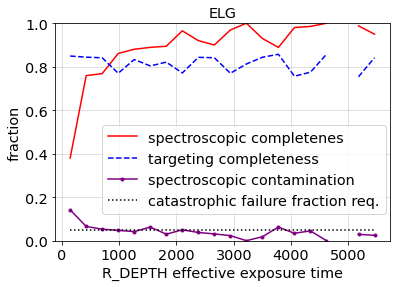

the target redshift range is 0.6<z<1.6
spectroscopic completeness is defined as the fraction of redshifts obained within the target range that have no zwarn flag, divided by the number of true redshifts within the target range (it does not exclude catastrophic failures)
targeting completeness is defined as the fraction of targets with true redshifts within the target range, divided by the total number of targets; variations are only due to variations in target properties in different tiles
spectroscopic contamination is defined as the fraction of redshifts, within the target range and with no zwarn flag, that are further than 0.0033(1+z_truth) from z_truth (cutting to the target redshift range and to zwarn == 0 in both numerator and denominator)


In [572]:
evalSR.effvsdepth(tf,'ELG',nbin=20,lplace=(.12,.09),depth='R_DEPTH')

/global/u2/a/ajross/LSS/Sandbox/evalSR.py:113: RuntimeWarning: invalid value encountered in true_divide
  plt.plot(hv,c[0]/e[0],'r-',label='spectroscopic completenes')
/global/u2/a/ajross/LSS/Sandbox/evalSR.py:114: RuntimeWarning: invalid value encountered in true_divide
  plt.plot(hv,e[0]/a[0],'b--',label='targeting completeness' )
/global/u2/a/ajross/LSS/Sandbox/evalSR.py:115: RuntimeWarning: invalid value encountered in true_divide
  plt.plot(hv,d[0]/c[0],'.-',color='purple',label= 'spectroscopic contamination' )


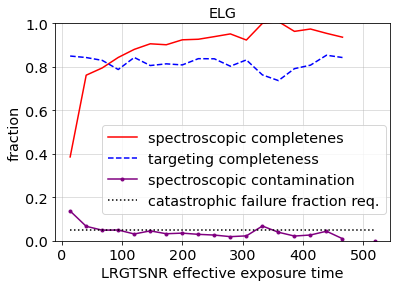

the target redshift range is 0.6<z<1.6
spectroscopic completeness is defined as the fraction of redshifts obained within the target range that have no zwarn flag, divided by the number of true redshifts within the target range (it does not exclude catastrophic failures)
targeting completeness is defined as the fraction of targets with true redshifts within the target range, divided by the total number of targets; variations are only due to variations in target properties in different tiles
spectroscopic contamination is defined as the fraction of redshifts, within the target range and with no zwarn flag, that are further than 0.0033(1+z_truth) from z_truth (cutting to the target redshift range and to zwarn == 0 in both numerator and denominator)


In [573]:
evalSR.effvsdepth(tf,'ELG',nbin=20,lplace=(.12,.09),depth='LRGTSNR')

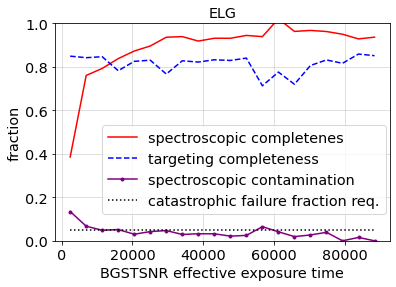

the target redshift range is 0.6<z<1.6
spectroscopic completeness is defined as the fraction of redshifts obained within the target range that have no zwarn flag, divided by the number of true redshifts within the target range (it does not exclude catastrophic failures)
targeting completeness is defined as the fraction of targets with true redshifts within the target range, divided by the total number of targets; variations are only due to variations in target properties in different tiles
spectroscopic contamination is defined as the fraction of redshifts, within the target range and with no zwarn flag, that are further than 0.0033(1+z_truth) from z_truth (cutting to the target redshift range and to zwarn == 0 in both numerator and denominator)


In [574]:
evalSR.effvsdepth(tf,'ELG',nbin=20,lplace=(.12,.09),depth='BGSTSNR')

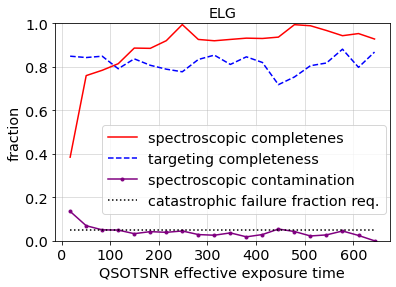

the target redshift range is 0.6<z<1.6
spectroscopic completeness is defined as the fraction of redshifts obained within the target range that have no zwarn flag, divided by the number of true redshifts within the target range (it does not exclude catastrophic failures)
targeting completeness is defined as the fraction of targets with true redshifts within the target range, divided by the total number of targets; variations are only due to variations in target properties in different tiles
spectroscopic contamination is defined as the fraction of redshifts, within the target range and with no zwarn flag, that are further than 0.0033(1+z_truth) from z_truth (cutting to the target redshift range and to zwarn == 0 in both numerator and denominator)


In [575]:
evalSR.effvsdepth(tf,'ELG',nbin=20,lplace=(.12,.09),depth='QSOTSNR')

In [1]:
import fitsio
import numpy as np

from matplotlib import pyplot as plt

In [8]:
from matplotlib import pyplot as plt
from astropy.table import Table,unique,join

In [3]:
dirz = '/global/cfs/cdirs/desi/survey/catalogs/SV1/redshift_comps/daily/v1/ELG'

In [9]:
fa = Table.read(dirz+'/alltiles_ELGzinfo.fits')

In [5]:
fa.dtype.names

('TARGETID',
 'CHI2',
 'COEFF',
 'Z',
 'ZERR',
 'ZWARN',
 'NPIXELS',
 'SPECTYPE',
 'SUBTYPE',
 'NCOEFF',
 'DELTACHI2',
 'NUMEXP',
 'NUMTILE',
 'PETAL_LOC',
 'DEVICE_LOC',
 'LOCATION',
 'FIBER',
 'FIBERSTATUS',
 'TARGET_RA',
 'TARGET_DEC',
 'PMRA',
 'PMDEC',
 'REF_EPOCH',
 'LAMBDA_REF',
 'FA_TARGET',
 'FA_TYPE',
 'OBJTYPE',
 'FIBERASSIGN_X',
 'FIBERASSIGN_Y',
 'NUMTARGET',
 'PRIORITY',
 'SUBPRIORITY',
 'OBSCONDITIONS',
 'MORPHTYPE',
 'FLUX_G',
 'FLUX_R',
 'FLUX_Z',
 'FLUX_IVAR_G',
 'FLUX_IVAR_R',
 'FLUX_IVAR_Z',
 'REF_ID',
 'REF_CAT',
 'GAIA_PHOT_G_MEAN_MAG',
 'GAIA_PHOT_BP_MEAN_MAG',
 'GAIA_PHOT_RP_MEAN_MAG',
 'PARALLAX',
 'EBV',
 'FLUX_W1',
 'FLUX_W2',
 'FIBERFLUX_G',
 'FIBERFLUX_R',
 'FIBERFLUX_Z',
 'FIBERTOTFLUX_G',
 'FIBERTOTFLUX_R',
 'FIBERTOTFLUX_Z',
 'MASKBITS',
 'SERSIC',
 'SHAPE_R',
 'SHAPE_E1',
 'SHAPE_E2',
 'PHOTSYS',
 'SV1_DESI_TARGET',
 'SV1_BGS_TARGET',
 'SV1_MWS_TARGET',
 'PRIORITY_INIT',
 'NUMOBS_INIT',
 'RELEASE',
 'BRICKID',
 'BRICKNAME',
 'BRICK_OBJID',
 'BLOBDIST',


In [6]:
pixfn      = '/global/cfs/cdirs/desi/target/catalogs/dr9/0.50.0/pixweight/main/resolve/dark/pixweight-1-dark.fits'
hdr        = fitsio.read_header(pixfn,ext=1)
nside,nest = hdr['HPXNSIDE'],hdr['HPXNEST']
print(nside,nest)


256 True


In [7]:
import healpy as hp

In [10]:
def radec2thphi(ra,dec):
    return (-dec+90.)*np.pi/180.,ra*np.pi/180.
    
def thphi2radec(theta,phi):
    return 180./np.pi*phi,-(180./np.pi*theta-90)


In [13]:
th,phi =radec2thphi(fa['TARGET_RA'],fa['TARGET_DEC'])
hpx = hp.ang2pix(nside,th,phi,nest=nest)

In [14]:
fp = fitsio.read(pixfn)

In [15]:
fp.dtype.names

('HPXPIXEL',
 'FRACAREA',
 'STARDENS',
 'EBV',
 'PSFDEPTH_G',
 'PSFDEPTH_R',
 'PSFDEPTH_Z',
 'GALDEPTH_G',
 'GALDEPTH_R',
 'GALDEPTH_Z',
 'PSFDEPTH_W1',
 'PSFDEPTH_W2',
 'PSFSIZE_G',
 'PSFSIZE_R',
 'PSFSIZE_Z',
 'FRACAREA_12290',
 'FRACAREA_8194',
 'ELG',
 'LRG',
 'QSO',
 'BGS_ANY',
 'MWS_ANY',
 'ALL',
 'STD_FAINT',
 'STD_BRIGHT',
 'BGS_FAINT',
 'BGS_BRIGHT',
 'BGS_WISE',
 'MWS_BROAD',
 'MWS_MAIN_RED',
 'MWS_MAIN_BLUE',
 'MWS_WD',
 'MWS_NEARBY')

In [16]:
len(fp)

786432

In [17]:
dg = np.zeros(len(fa))
dr = np.zeros(len(fa))
dz = np.zeros(len(fa))

In [18]:
for i in range(0,len(dg)):
    dg[i] = fp['GALDEPTH_G'][hpx[i]]

(array([ 536., 5715., 8752., 3446.,  511., 1283., 2829., 3479., 2602.,
         501.]),
 array([ 387.42294312,  636.91946716,  886.41599121, 1135.91251526,
        1385.40903931, 1634.90556335, 1884.4020874 , 2133.89861145,
        2383.3951355 , 2632.89165955, 2882.38818359]),
 <a list of 10 Patch objects>)

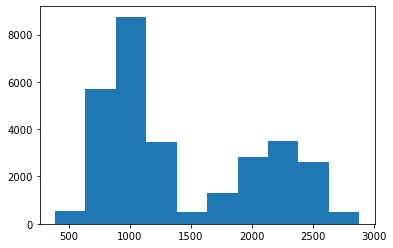

In [41]:
plt.hist(dg[wz])

In [20]:
fa['GALDEPTH_G'] = dg

In [40]:
rdmin = 1000
wz = fa['FIBERSTATUS'] == 0
wz &= fa['ZWARN'] == 0
wz &= fa['R_DEPTH_EBVAIR'] > rdmin
wz &= fa['PHOTSYS'] == 'S'
print(len(fa),len(fa[wz]))

163819 29654


(array([2.0780e+03, 4.6147e+04, 5.5745e+04, 4.9438e+04, 6.1058e+04,
        3.9039e+04, 2.0522e+04, 1.4791e+04, 1.7414e+04, 2.0575e+04,
        1.9897e+04, 1.4944e+04, 9.3760e+03, 5.0180e+03, 2.4460e+03,
        1.2730e+03, 6.5800e+02, 3.6800e+02, 2.1600e+02, 1.1600e+02,
        8.3000e+01, 3.2000e+01, 6.0000e+00, 8.0000e+00, 1.4000e+01,
        5.0000e+00, 3.0000e+00, 3.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([   9.32486,  238.24178,  467.1587 ,  696.0756 ,  924.99255,
        1153.9094 , 1382.8264 , 1611.7433 , 1840.6603 , 2069.5771 ,
        2298.4941 , 2527.411  , 2756.328  , 2985.2449 , 3214.1619 ,
        3443.0786 , 3671.9956 , 3900.9126 , 4129.8296 , 4358.7466 ,
        4587.663  , 4816.58   , 5045.497  , 5274.414  , 5503.331  ,
        5732.248  , 5961.165  , 6190.0815 , 6418.9985 , 6647.9155 ,
        6876.8325 ], dtype=float32),
 <a list of 30 Patch objects>)

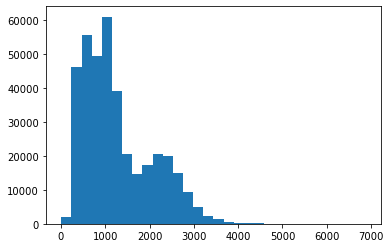

In [28]:
wn = fp['GALDEPTH_G'] > 0
plt.hist(fp['GALDEPTH_G'][wn],bins=30)

In [42]:
fz = fa[wz]

In [43]:
ws = fz['GALDEPTH_G'] > 1500
print(sum(fz[ws]['elgqso_weight']),len(fz[~ws]['elgqso_weight']))

9432.103999999812 18675


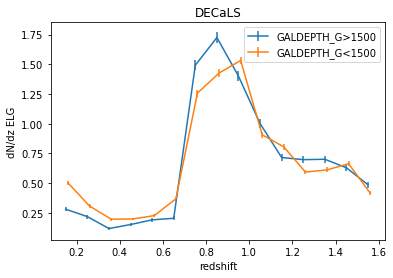

Text(0.5, 1.0, 'DECaLS ELGs, splitting on GALDEPTH_G at 1500')

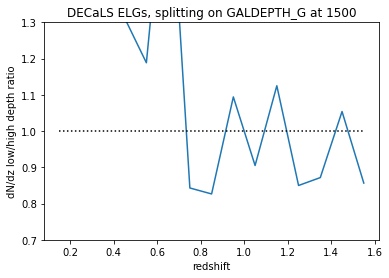

In [60]:
nbin = 15
rng = (0.1,1.6)
bs = (rng[1]-rng[0])/nbin
a = plt.hist(fz[ws]['Z'],histtype='step',bins=nbin,range=rng,weights=fz[ws]['elgqso_weight'],label='GALDEPTH_G>1500')
b = plt.hist(fz[~ws]['Z'],histtype='step',bins=nbin,range=rng,weights=fz[~ws]['elgqso_weight'],label='GALDEPTH_G<1500')
plt.clf()
zl = a[1][:-1]+0.05
an = a[0]/np.sum(a[0])/bs
bn = b[0]/np.sum(b[0])/bs
plt.errorbar(zl,an,np.sqrt(a[0])/np.sum(a[0])/bs,label='GALDEPTH_G>1500')
plt.errorbar(zl+0.01,bn,np.sqrt(b[0])/np.sum(b[0])/bs,label='GALDEPTH_G<1500')
plt.legend()
plt.xlabel('redshift')
plt.ylabel('dN/dz ELG')
plt.title('DECaLS')
plt.show()
plt.plot(zl,bn/an)
ol = np.ones(len(bn))
plt.plot(zl,ol,':k')
plt.ylim(0.7,1.3)
plt.xlabel('redshift')
plt.ylabel('dN/dz low/high depth ratio')
plt.title('DECaLS ELGs, splitting on GALDEPTH_G at 1500')

In [61]:
rdmin = 1000
wz = fa['FIBERSTATUS'] == 0
wz &= fa['ZWARN'] == 0
wz &= fa['R_DEPTH_EBVAIR'] > rdmin
wz &= fa['PHOTSYS'] == 'N'
print(len(fa),len(fa[wz]))

163819 26717


(array([ 249., 5085., 8369., 8087., 3506., 1296.,   47.,   37.,   30.,
          11.]),
 array([ 250.99501038,  360.19809723,  469.40118408,  578.60427094,
         687.80735779,  797.01044464,  906.21353149, 1015.41661835,
        1124.6197052 , 1233.82279205, 1343.02587891]),
 <a list of 10 Patch objects>)

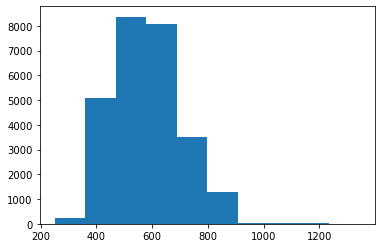

In [62]:
plt.hist(dg[wz])

In [70]:
fz = fa[wz]
ws = fz['GALDEPTH_G'] > 550
print(sum(fz[ws]['elgqso_weight']),len(fz[~ws]['elgqso_weight']))

13160.932000000368 11690


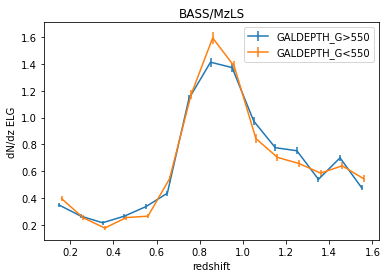

Text(0.5, 1.0, 'BASS/MzLS ELGs, splitting on GALDEPTH_G at 550')

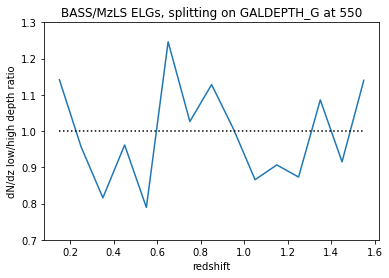

In [71]:
nbin = 15
rng = (0.1,1.6)
bs = (rng[1]-rng[0])/nbin
a = plt.hist(fz[ws]['Z'],histtype='step',bins=nbin,range=rng,weights=fz[ws]['elgqso_weight'],label='GALDEPTH_G>550')
b = plt.hist(fz[~ws]['Z'],histtype='step',bins=nbin,range=rng,weights=fz[~ws]['elgqso_weight'],label='GALDEPTH_G<550')
plt.clf()
zl = a[1][:-1]+0.05
an = a[0]/np.sum(a[0])/bs
bn = b[0]/np.sum(b[0])/bs
plt.errorbar(zl,an,np.sqrt(a[0])/np.sum(a[0])/bs,label='GALDEPTH_G>550')
plt.errorbar(zl+0.01,bn,np.sqrt(b[0])/np.sum(b[0])/bs,label='GALDEPTH_G<550')
plt.legend()
plt.xlabel('redshift')
plt.ylabel('dN/dz ELG')
plt.title('BASS/MzLS')
plt.show()
plt.plot(zl,bn/an)
ol = np.ones(len(bn))
plt.plot(zl,ol,':k')
plt.ylim(0.7,1.3)
plt.xlabel('redshift')
plt.ylabel('dN/dz low/high depth ratio')
plt.title('BASS/MzLS ELGs, splitting on GALDEPTH_G at 550')

In [74]:
f = fitsio.read('/global/cscratch1/sd/ajross/gfa_reduce/gfa_reduce/py/scripts/offline_matched_coadd_ccds_SV1-thru_20210202.fits')

In [75]:
len(f)

96

In [76]:
f.dtype.names

('MEDIAN',
 'MEAN',
 'N_NON_FINITE',
 'MAX',
 'MIN',
 'SIG_ROBUST',
 'SIG',
 'MEDIAN_Q1',
 'MEAN_Q1',
 'N_NON_FINITE_Q1',
 'MAX_Q1',
 'MIN_Q1',
 'SIG_ROBUST_Q1',
 'SIG_Q1',
 'MEDIAN_Q2',
 'MEAN_Q2',
 'N_NON_FINITE_Q2',
 'MAX_Q2',
 'MIN_Q2',
 'SIG_ROBUST_Q2',
 'SIG_Q2',
 'MEDIAN_Q3',
 'MEAN_Q3',
 'N_NON_FINITE_Q3',
 'MAX_Q3',
 'MIN_Q3',
 'SIG_ROBUST_Q3',
 'SIG_Q3',
 'MEDIAN_Q4',
 'MEAN_Q4',
 'N_NON_FINITE_Q4',
 'MAX_Q4',
 'MIN_Q4',
 'SIG_ROBUST_Q4',
 'SIG_Q4',
 'CAMERA',
 'EXTNAME',
 'CONTRAST',
 'SKY_MAG_AB',
 'SKY_MAG_AB_SUBREGION',
 'SKY_MAG_AB_PER_AMP',
 'PETAL_LOC',
 'EXPID',
 'MJD',
 'LST_DEG',
 'MOON_ILLUMINATION',
 'PROGRAM',
 'SKYRA',
 'SKYDEC',
 'ZENITH_DIST_DEG',
 'DOMSHUTL',
 'DOMSHUTU',
 'PMCOVER',
 'MOONRA',
 'MOONDEC',
 'MOON_ZD_DEG',
 'T_C_FOR_DARK',
 'T_C_FOR_DARK_IS_GUESS',
 'TIME_S_FOR_DARK',
 'NIGHT',
 'FOCUS',
 'EXPTIME',
 'CUBE_INDEX',
 'COADD_INDEX_START',
 'COADD_INDEX_END',
 'COADD_MJDOBS_MIN',
 'COADD_MJDOBS_MAX',
 'RACEN',
 'DECCEN',
 'FNAME_RAW',
 'GITREV',
 

In [82]:
len(np.unique(f['CAMERA']))*len(np.unique(f['EXPID']))

96

In [80]:
len(f)

96

In [83]:
len(np.unique(f['EXPID']))

16

In [84]:
len(np.unique(f['CAMERA']))

6

In [2]:
expf = '/global/cfs/cdirs/desi/survey/observations/SV1/sv1-exposures.fits'  
exposures = fitsio.read(expf) #this will be used in depth calculations  


In [3]:
exposures.dtype.names

('NIGHT',
 'EXPID',
 'FIELD',
 'TARGETS',
 'EBV',
 'SPECMODEL_SKY_RMAG_AB',
 'HASGFA',
 'B_DEPTH',
 'R_DEPTH',
 'Z_DEPTH',
 'B_DEPTH_EBVAIR',
 'R_DEPTH_EBVAIR',
 'Z_DEPTH_EBVAIR',
 'BITPSFFN',
 'BITFRAMEFN',
 'BITSKYFN',
 'BITSFRAMEFN',
 'BITFLUXCALIBFN',
 'BITCFRAMEFN',
 'TGT',
 'SKY',
 'STD',
 'WD',
 'LRG',
 'ELG',
 'QSO',
 'BGS',
 'MWS',
 'TILEID',
 'TILERA',
 'TILEDEC',
 'EXPTIME',
 'MJDOBS',
 'GFA_AIRMASS',
 'GFA_MOON_ILLUMINATION',
 'GFA_MOON_ZD_DEG',
 'GFA_MOON_SEP_DEG',
 'GFA_TRANSPARENCY',
 'GFA_FWHM_ASEC',
 'GFA_SKY_MAG_AB',
 'GFA_FIBER_FRACFLUX',
 'GFA_FIBER_FRACFLUX_ELG',
 'GFA_TRANSPFRAC',
 'GFA_MAXCONTRAST',
 'GFA_MINCONTRAST',
 'GFA_KTERM',
 'GFA_RADPROF_FWHM_ASEC')

In [5]:
np.unique(exposures['TILEID'])

array([80605, 80606, 80607, 80608, 80609, 80610, 80611, 80612, 80613,
       80614, 80615, 80616, 80617, 80618, 80619, 80620, 80621, 80622,
       80623, 80624, 80626, 80627, 80628, 80629, 80632, 80633, 80635,
       80636, 80637, 80638, 80639, 80640, 80641, 80642, 80643, 80644,
       80645, 80646, 80648, 80649, 80650, 80651, 80653, 80654, 80655,
       80656, 80658, 80659, 80660, 80661, 80662, 80663, 80664, 80665,
       80666, 80669, 80670, 80673, 80674, 80675, 80676, 80677, 80678,
       80679, 80680, 80681, 80682, 80683, 80684, 80685, 80688, 80690,
       80692, 80693, 80694, 80699, 80700, 80701, 80705, 80707, 80709,
       80711, 80713, 80715, 80718, 80719, 80720, 80733, 80735, 80742])

In [7]:
wt = exposures['TILEID'] == int('80605')
np.unique(exposures[wt]['EXPID'])

array([67710, 67711, 67712, 67713, 67972, 67973, 67974, 67975, 67987,
       68290, 68291, 68292, 69135, 69136, 69139, 69140, 69141, 69142,
       69143, 69359, 69361, 69363, 71594, 71595, 73702, 73704, 73705,
       73870, 73872, 74779, 74780, 74781, 74782, 74783])

In [8]:
f = fitsio.read('/global/cscratch1/sd/mjwilson/desi/tsnr/blanc/exptables/v0/summary_b3.fits')

In [9]:
f.dtype.names

('EXPID',
 'NIGHT',
 'CAMERA',
 'ALPHA',
 'ELGTSNR',
 'BGSTSNR',
 'QSOTSNR',
 'LRGTSNR')

In [10]:
np.unique(f['EXPID'])

array(['00067733', '00067744', '00067765', '00067766', '00067767',
       '00067768', '00067769', '00067770', '00067771', '00067781',
       '00067782', '00067783', '00067784', '00067968', '00067969',
       '00067970', '00067971', '00067972', '00067973', '00067974',
       '00067975', '00067987', '00068013', '00068023', '00068024',
       '00068025', '00068026', '00068027', '00068028', '00068039',
       '00068040', '00068041', '00068042', '00068063', '00068064',
       '00068065', '00068265', '00068266', '00068272', '00068273',
       '00068284', '00068285', '00068288', '00068289', '00068290',
       '00068291', '00068292', '00068317', '00068327', '00068328',
       '00068330', '00068331', '00068332', '00068333', '00068334',
       '00068336', '00068337', '00068338', '00068339', '00068340',
       '00068477', '00068478', '00068488', '00068489', '00068490',
       '00068491', '00068492', '00068644', '00068645', '00068646',
       '00068657', '00068658', '00068659', '00068660', '000686

In [11]:
exp = 67972
info = f[f['EXPID'] == '000'+str(exp)] 

In [12]:
len(info)

1

In [30]:
f = fitsio.read(os.environ['CSCRATCH']+'/SV1/redshift_comps/blanc/test1exp/ELG/80606_ELGzinfo_1exp.fits')

In [31]:
f.dtype.names

('TARGETID',
 'CHI2',
 'COEFF',
 'Z',
 'ZERR',
 'ZWARN',
 'NPIXELS',
 'SPECTYPE',
 'SUBTYPE',
 'NCOEFF',
 'DELTACHI2',
 'NUMEXP',
 'NUMTILE',
 'PETAL_LOC',
 'DEVICE_LOC',
 'LOCATION',
 'FIBER',
 'FIBERSTATUS',
 'TARGET_RA',
 'TARGET_DEC',
 'PMRA',
 'PMDEC',
 'REF_EPOCH',
 'LAMBDA_REF',
 'FA_TARGET',
 'FA_TYPE',
 'OBJTYPE',
 'FIBERASSIGN_X',
 'FIBERASSIGN_Y',
 'NUMTARGET',
 'PRIORITY',
 'SUBPRIORITY',
 'OBSCONDITIONS',
 'MORPHTYPE',
 'FLUX_G',
 'FLUX_R',
 'FLUX_Z',
 'FLUX_IVAR_G',
 'FLUX_IVAR_R',
 'FLUX_IVAR_Z',
 'REF_ID',
 'REF_CAT',
 'GAIA_PHOT_G_MEAN_MAG',
 'GAIA_PHOT_BP_MEAN_MAG',
 'GAIA_PHOT_RP_MEAN_MAG',
 'PARALLAX',
 'EBV',
 'FLUX_W1',
 'FLUX_W2',
 'FIBERFLUX_G',
 'FIBERFLUX_R',
 'FIBERFLUX_Z',
 'FIBERTOTFLUX_G',
 'FIBERTOTFLUX_R',
 'FIBERTOTFLUX_Z',
 'MASKBITS',
 'SERSIC',
 'SHAPE_R',
 'SHAPE_E1',
 'SHAPE_E2',
 'PHOTSYS',
 'SV1_DESI_TARGET',
 'SV1_BGS_TARGET',
 'SV1_MWS_TARGET',
 'PRIORITY_INIT',
 'NUMOBS_INIT',
 'RELEASE',
 'BRICKID',
 'BRICKNAME',
 'BRICK_OBJID',
 'BLOBDIST',


In [55]:
wz = f['ZWARN'] == 0
wz &= f['FIBERSTATUS'] == 0
wz &= f['ZWARN_deep']*0 == 0

In [22]:
len(np.unique(f['EXPID']))

12

In [25]:
len(f[wz])

25131

In [52]:
wf = f['FIBERSTATUS'] == 0
wf &= f['ZWARN_deep'] == 0
#wf &= f['ZWARN_deep'] == 0

In [34]:
len(f[wf])

34337

array([0.42433015, 0.66577009, 0.72339626, 0.80012874, 0.80810498,
       0.80788029, 0.79794567, 0.79221707, 0.78994413, 0.78584392])

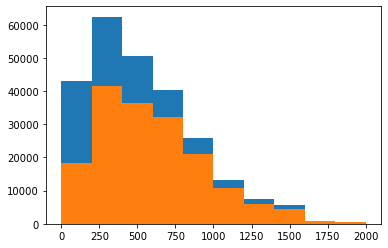

In [60]:
a = plt.hist(f[wf]['ELGTSNR'],range=(0,2000))
b = plt.hist(f[wz]['ELGTSNR'],range=(0,2000))
b[0]/a[0]

In [40]:
f = fitsio.read('/global/cscratch1/sd/ajross/SV1/redshift_comps/blanc/test1exp/All/80606_Allzinfo.fits')

In [41]:
len(f)

34500

In [42]:
np.unique(f['subset'])

array(['20201214', '20201215', '20201216', '20201218', '20201219', 'all',
       'deep'], dtype='<U8')

In [1]:
f = fitsio.read('/global/cfs/cdirs/desi/survey/catalogs/SV1/redshift_comps/blanc/v2/QSO/alltiles_QSOzinfo.fits')

NameError: name 'fitsio' is not defined

In [20]:
len(f)

543500

In [40]:
w = f['subset'] == 'deep'

In [31]:
len(f[w]),len(np.unique(f[w]['TARGETID']))

(85000, 83097)

In [41]:
#wz = f[w]['SPECTYPE'] == 'QSO'
wz = f[w]['Z'] > 2.1

In [42]:
len(f[w][wz]),len(np.unique(f[w][wz]['TARGETID']))

(655, 628)

In [25]:
np.unique(f[w][wz]['TARGETS'])

array(['BGS+MWS', 'ELG', 'QSO+LRG'], dtype='<U7')

In [37]:
np.unique(f['TILEID'])

array([80605, 80606, 80607, 80608, 80609, 80610, 80611, 80612, 80613,
       80614, 80616, 80617, 80618, 80619, 80620, 80621, 80622, 80623],
      dtype=int32)

In [38]:
np.unique(f[w]['TILEID'])

array([80605, 80606, 80607, 80608, 80609, 80610, 80611, 80612, 80613,
       80614, 80616, 80617, 80618, 80619, 80620, 80621, 80622, 80623],
      dtype=int32)

Text(0.5, 1.0, 'targeted as a QSO')

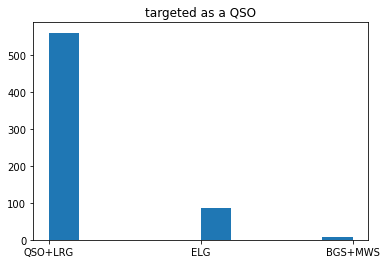

In [44]:
plt.hist(f[w][wz]['TARGETS'])
plt.title('targeted as a QSO')

In [50]:
f = fitsio.read('/global/cfs/cdirs/desi/survey/catalogs/SV1/redshift_comps/blanc/v2/ELG/alltiles_ELGzinfo_1exp.fits')

In [51]:
len(f)

372447

In [71]:
f = fitsio.read('/global/cfs/cdirs/desi/survey/catalogs/SV1/redshift_comps/blanc/v2/ELG/80608_ELGzinfo_1exp.fits')

In [72]:
f.dtype.names

('TARGETID',
 'CHI2',
 'COEFF',
 'Z',
 'ZERR',
 'ZWARN',
 'NPIXELS',
 'SPECTYPE',
 'SUBTYPE',
 'NCOEFF',
 'DELTACHI2',
 'NUMEXP',
 'NUMTILE',
 'PETAL_LOC',
 'DEVICE_LOC',
 'LOCATION',
 'FIBER',
 'FIBERSTATUS',
 'TARGET_RA',
 'TARGET_DEC',
 'PMRA',
 'PMDEC',
 'REF_EPOCH',
 'LAMBDA_REF',
 'FA_TARGET',
 'FA_TYPE',
 'OBJTYPE',
 'FIBERASSIGN_X',
 'FIBERASSIGN_Y',
 'NUMTARGET',
 'PRIORITY',
 'SUBPRIORITY',
 'OBSCONDITIONS',
 'MORPHTYPE',
 'FLUX_G',
 'FLUX_R',
 'FLUX_Z',
 'FLUX_IVAR_G',
 'FLUX_IVAR_R',
 'FLUX_IVAR_Z',
 'REF_ID',
 'REF_CAT',
 'GAIA_PHOT_G_MEAN_MAG',
 'GAIA_PHOT_BP_MEAN_MAG',
 'GAIA_PHOT_RP_MEAN_MAG',
 'PARALLAX',
 'EBV',
 'FLUX_W1',
 'FLUX_W2',
 'FIBERFLUX_G',
 'FIBERFLUX_R',
 'FIBERFLUX_Z',
 'FIBERTOTFLUX_G',
 'FIBERTOTFLUX_R',
 'FIBERTOTFLUX_Z',
 'MASKBITS',
 'SERSIC',
 'SHAPE_R',
 'SHAPE_E1',
 'SHAPE_E2',
 'PHOTSYS',
 'SV1_DESI_TARGET',
 'SV1_BGS_TARGET',
 'SV1_MWS_TARGET',
 'PRIORITY_INIT',
 'NUMOBS_INIT',
 'RELEASE',
 'BRICKID',
 'BRICKNAME',
 'BRICK_OBJID',
 'BLOBDIST',


In [67]:
f = Table.read('/global/cfs/cdirs/desi/target/analysis/truth/dr9.0/north/matched/ls-dr9.0-DR16Q_v4-match.fits')

In [64]:
len(f)

374408

In [65]:
f.dtype.names

('RELEASE',
 'BRICKID',
 'BRICKNAME',
 'OBJID',
 'TYPE',
 'RA',
 'DEC',
 'RA_IVAR',
 'DEC_IVAR',
 'DCHISQ',
 'EBV',
 'FLUX_G',
 'FLUX_R',
 'FLUX_Z',
 'FLUX_W1',
 'FLUX_W2',
 'FLUX_W3',
 'FLUX_W4',
 'FLUX_IVAR_G',
 'FLUX_IVAR_R',
 'FLUX_IVAR_Z',
 'FLUX_IVAR_W1',
 'FLUX_IVAR_W2',
 'FLUX_IVAR_W3',
 'FLUX_IVAR_W4',
 'MW_TRANSMISSION_G',
 'MW_TRANSMISSION_R',
 'MW_TRANSMISSION_Z',
 'MW_TRANSMISSION_W1',
 'MW_TRANSMISSION_W2',
 'MW_TRANSMISSION_W3',
 'MW_TRANSMISSION_W4',
 'NOBS_G',
 'NOBS_R',
 'NOBS_Z',
 'NOBS_W1',
 'NOBS_W2',
 'NOBS_W3',
 'NOBS_W4',
 'RCHISQ_G',
 'RCHISQ_R',
 'RCHISQ_Z',
 'RCHISQ_W1',
 'RCHISQ_W2',
 'RCHISQ_W3',
 'RCHISQ_W4',
 'FRACFLUX_G',
 'FRACFLUX_R',
 'FRACFLUX_Z',
 'FRACFLUX_W1',
 'FRACFLUX_W2',
 'FRACFLUX_W3',
 'FRACFLUX_W4',
 'FRACMASKED_G',
 'FRACMASKED_R',
 'FRACMASKED_Z',
 'FRACIN_G',
 'FRACIN_R',
 'FRACIN_Z',
 'ANYMASK_G',
 'ANYMASK_R',
 'ANYMASK_Z',
 'ALLMASK_G',
 'ALLMASK_R',
 'ALLMASK_Z',
 'WISEMASK_W1',
 'WISEMASK_W2',
 'PSFSIZE_G',
 'PSFSIZE_R',
 'PSFSIZE_

In [68]:
from desitarget import targets
f['targetid'] = targets.encode_targetid(f['OBJID'], f['BRICKID'], f['RELEASE'])

In [ ]:
dirf = '/global/cfs/cdirs/desi/users/forero/DR9mfiberassign/dark/fiberassign'